# Fruit Recognition with Image Segmentation and Classification

This notebook implements a two-stage approach for recognizing fruits in images:
1. **Image Segmentation**: Identify and isolate individual fruits in the image
2. **Classification**: Classify each segmented fruit using our trained classification model

This approach can be more accurate than direct object detection in certain scenarios, particularly when:
- The fruits may be overlapping or clustered
- The lighting conditions vary
- We need very precise classification of each individual fruit

## 1. Setup and Import Libraries

In [2]:
# Basic data handling and utilities
import os
import numpy as np
import pandas as pd
from pathlib import Path
import random
import shutil
from tqdm.notebook import tqdm
import yaml
import json

# Image processing
import cv2
from PIL import Image
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from skimage.measure import label, regionprops
from scipy import ndimage

# Data visualization
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

# PyTorch and related libraries
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

# Ultralytics for YOLO
from ultralytics import YOLO

# For reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Check for GPU availability
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Create directory for segmentation results
results_dir = os.path.join("..", "results", "fruit_segmentation")
os.makedirs(results_dir, exist_ok=True)

Using device: cuda:0


## 2. Load the Trained Classification Model

First, we'll load our best trained classification model from the previous notebook.

In [3]:
# Paths to the trained model and class names
model_dir = os.path.join("..", "models", "fruits_classifier")
model_path = os.path.join(model_dir, "best.pt")
class_file = os.path.join(model_dir, "classes.txt")

# Load class names
class_names = []
if os.path.exists(class_file):
    with open(class_file, 'r') as f:
        class_names = [line.strip() for line in f.readlines()]
else:
    # Load from data.yaml if classes.txt doesn't exist
    yaml_path = os.path.join("..", "datasets", "fruits_yolo", "data.yaml")
    with open(yaml_path, 'r') as f:
        data_config = yaml.safe_load(f)
        class_names = data_config['names']

print(f"Loaded {len(class_names)} class names")

# Load the trained classification model
if os.path.exists(model_path):
    classifier = YOLO(model_path)
    print(f"Loaded classification model from {model_path}")
else:
    print(f"Warning: Model not found at {model_path}")
    print("Using a pre-trained model instead")
    classifier = YOLO("yolov8n-cls.pt")

Loaded 76 class names
Loaded classification model from ../models/fruits_classifier/best.pt
Loaded classification model from ../models/fruits_classifier/best.pt


## 3. Image Segmentation Functions

We'll implement several segmentation approaches to handle different types of images:

1. **Color-based segmentation** - Uses color thresholding to identify fruits
2. **Watershed segmentation** - Separates touching/overlapping fruits
3. **Contour-based segmentation** - Identifies distinct objects based on contours

In [4]:
def preprocess_image(image_path, resize_dim=None):
    """
    Preprocess the image for segmentation
    
    Args:
        image_path: Path to the image
        resize_dim: Optional dimension to resize the image to
    
    Returns:
        Original image, preprocessed image
    """
    # Read the image
    if isinstance(image_path, str):
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    else:
        img = image_path  # Assume already a numpy array in RGB
    
    # Resize if specified
    if resize_dim is not None:
        img = cv2.resize(img, (resize_dim, resize_dim))
    
    # Create a copy for preprocessing
    processed = img.copy()
    
    # Apply slight Gaussian blur to reduce noise
    processed = cv2.GaussianBlur(processed, (5, 5), 0)
    
    return img, processed

def segment_by_color(image, show_steps=False):
    """
    Segment an image based on color thresholding
    
    Args:
        image: Input image (RGB)
        show_steps: Whether to display intermediate steps
    
    Returns:
        List of segmented regions (masks and bounding boxes)
    """
    # Convert to HSV color space for better color segmentation
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    
    # Define color ranges for common fruits
    # These ranges can be tuned based on your specific images
    color_ranges = [
        # Red fruits (apples, strawberries, etc.)
        (np.array([0, 100, 100]), np.array([10, 255, 255])),
        (np.array([160, 100, 100]), np.array([180, 255, 255])),
        
        # Yellow/Orange fruits (bananas, oranges)
        (np.array([15, 100, 100]), np.array([30, 255, 255])),
        
        # Green fruits (apples, pears)
        (np.array([35, 40, 40]), np.array([85, 255, 255])),
        
        # Purple/Blue fruits (grapes, blueberries)
        (np.array([90, 40, 40]), np.array([140, 255, 255]))
    ]
    
    # Combine masks from all color ranges
    combined_mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)
    
    for lower, upper in color_ranges:
        # Create a mask for the current color range
        mask = cv2.inRange(hsv, lower, upper)
        
        # Combine with the overall mask
        combined_mask = cv2.bitwise_or(combined_mask, mask)
    
    # Apply morphological operations to clean up the mask
    kernel = np.ones((5, 5), np.uint8)
    mask_cleaned = cv2.morphologyEx(combined_mask, cv2.MORPH_OPEN, kernel)
    mask_cleaned = cv2.morphologyEx(mask_cleaned, cv2.MORPH_CLOSE, kernel)
    
    if show_steps:
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(image)
        plt.title('Original Image')
        plt.axis('off')
        
        plt.subplot(1, 3, 2)
        plt.imshow(combined_mask, cmap='gray')
        plt.title('Combined Color Mask')
        plt.axis('off')
        
        plt.subplot(1, 3, 3)
        plt.imshow(mask_cleaned, cmap='gray')
        plt.title('Cleaned Mask')
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()
    
    # Find contours in the mask
    contours, _ = cv2.findContours(mask_cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Filter out small contours
    min_contour_area = 100  # Adjust as needed
    valid_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_contour_area]
    
    # Extract regions from the contours
    regions = []
    for i, contour in enumerate(valid_contours):
        # Create a mask for this contour
        mask = np.zeros_like(mask_cleaned)
        cv2.drawContours(mask, [contour], 0, 255, -1)
        
        # Get bounding box
        x, y, w, h = cv2.boundingRect(contour)
        
        # Add some padding
        padding = 10
        x_pad = max(0, x - padding)
        y_pad = max(0, y - padding)
        w_pad = min(image.shape[1] - x_pad, w + 2*padding)
        h_pad = min(image.shape[0] - y_pad, h + 2*padding)
        
        regions.append({
            'mask': mask,
            'bbox': (x_pad, y_pad, w_pad, h_pad),
            'area': cv2.contourArea(contour),
            'centroid': (x + w//2, y + h//2)
        })
    
    return regions

def segment_with_watershed(image, show_steps=False):
    """
    Segment an image using the watershed algorithm
    
    Args:
        image: Input image (RGB)
        show_steps: Whether to display intermediate steps
    
    Returns:
        List of segmented regions (masks and bounding boxes)
    """
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # Apply thresholding
    _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
    
    # Noise removal with morphological operations
    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
    
    # Sure background area
    sure_bg = cv2.dilate(opening, kernel, iterations=3)
    
    # Finding sure foreground area
    dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    _, sure_fg = cv2.threshold(dist_transform, 0.5*dist_transform.max(), 255, 0)
    sure_fg = sure_fg.astype(np.uint8)
    
    # Finding unknown region
    unknown = cv2.subtract(sure_bg, sure_fg)
    
    # Marker labelling
    _, markers = cv2.connectedComponents(sure_fg)
    
    # Add one to all labels so that background is not 0, but 1
    markers = markers + 1
    
    # Mark the region of unknown with zero
    markers[unknown == 255] = 0
    
    # Apply watershed
    markers = cv2.watershed(image, markers)
    
    if show_steps:
        plt.figure(figsize=(15, 10))
        plt.subplot(2, 3, 1)
        plt.imshow(image)
        plt.title('Original Image')
        plt.axis('off')
        
        plt.subplot(2, 3, 2)
        plt.imshow(thresh, cmap='gray')
        plt.title('Thresholded')
        plt.axis('off')
        
        plt.subplot(2, 3, 3)
        plt.imshow(sure_bg, cmap='gray')
        plt.title('Sure Background')
        plt.axis('off')
        
        plt.subplot(2, 3, 4)
        plt.imshow(sure_fg, cmap='gray')
        plt.title('Sure Foreground')
        plt.axis('off')
        
        plt.subplot(2, 3, 5)
        plt.imshow(dist_transform, cmap='hot')
        plt.title('Distance Transform')
        plt.axis('off')
        
        plt.subplot(2, 3, 6)
        plt.imshow(markers, cmap='nipy_spectral')
        plt.title('Watershed Markers')
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()
    
    # Extract regions from watershed result
    regions = []
    for label in np.unique(markers):
        # Skip background label (1) and boundary (-1)
        if label <= 1:
            continue
        
        # Create a mask for this region
        mask = np.zeros_like(gray, dtype=np.uint8)
        mask[markers == label] = 255
        
        # Apply some morphological operations to clean up the mask
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=2)
        
        # Find contours in the mask
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        if contours:
            # Get the largest contour (should be only one, but just in case)
            contour = max(contours, key=cv2.contourArea)
            
            # Get bounding box
            x, y, w, h = cv2.boundingRect(contour)
            
            # Skip very small regions
            if w * h < 100:
                continue
                
            # Add some padding
            padding = 10
            x_pad = max(0, x - padding)
            y_pad = max(0, y - padding)
            w_pad = min(image.shape[1] - x_pad, w + 2*padding)
            h_pad = min(image.shape[0] - y_pad, h + 2*padding)
            
            regions.append({
                'mask': mask,
                'bbox': (x_pad, y_pad, w_pad, h_pad),
                'area': cv2.contourArea(contour),
                'centroid': (x + w//2, y + h//2)
            })
    
    return regions

def combined_segmentation(image_path, show_steps=False):
    """
    Apply multiple segmentation methods and combine the results
    
    Args:
        image_path: Path to the image or image array
        show_steps: Whether to display intermediate steps
    
    Returns:
        Original image, list of segmented regions
    """
    # Preprocess the image
    original, processed = preprocess_image(image_path)
    
    # Apply color-based segmentation
    color_regions = segment_by_color(processed, show_steps=show_steps)
    
    # Apply watershed segmentation
    watershed_regions = segment_with_watershed(processed, show_steps=show_steps)
    
    # Combine regions from both methods
    # For simplicity, we'll just concatenate them
    all_regions = color_regions + watershed_regions
    
    # Remove duplicate or overlapping regions
    filtered_regions = []
    centroids = []
    
    for region in sorted(all_regions, key=lambda r: -r['area']):
        # Check if this region overlaps significantly with any existing region
        x, y, w, h = region['bbox']
        centroid = region['centroid']
        
        # Skip if centroid is too close to an existing one
        is_duplicate = False
        for existing_centroid in centroids:
            dist = np.sqrt((centroid[0] - existing_centroid[0])**2 + 
                          (centroid[1] - existing_centroid[1])**2)
            if dist < 50:  # Adjust threshold as needed
                is_duplicate = True
                break
        
        if not is_duplicate:
            filtered_regions.append(region)
            centroids.append(centroid)
    
    # Visualize the segmentation results if requested
    if show_steps:
        plt.figure(figsize=(10, 10))
        plt.imshow(original)
        plt.title('Segmentation Results')
        
        for i, region in enumerate(filtered_regions):
            x, y, w, h = region['bbox']
            rect = plt.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
            plt.gca().add_patch(rect)
            plt.text(x, y, f"Region {i+1}", color='white', fontsize=12, 
                    bbox=dict(facecolor='red', alpha=0.5))
        
        plt.axis('off')
        plt.tight_layout()
        plt.show()
    
    return original, filtered_regions

## 4. Classification of Segmented Regions

Now we'll define functions to classify each segmented region using our trained model.

In [5]:
def classify_region(img, region, classifier, class_names):
    """
    Classify a segmented region using the trained classifier
    
    Args:
        img: Original image
        region: Dictionary containing region information
        classifier: Trained YOLO classification model
        class_names: List of class names
    
    Returns:
        Dictionary with classification results
    """
    # Extract the region from the image
    x, y, w, h = region['bbox']
    roi = img[y:y+h, x:x+w].copy()
    
    # Skip if ROI is empty
    if roi.size == 0 or roi.shape[0] == 0 or roi.shape[1] == 0:
        return {
            'class': 'unknown',
            'confidence': 0,
            'top_classes': []
        }
    
    # Convert to PIL Image for saving if needed
    roi_pil = Image.fromarray(roi)
    
    # Run classification
    results = classifier(roi)
    
    # Extract top predictions
    if hasattr(results[0], 'probs'):
        probs = results[0].probs.data.tolist()
        top_indices = sorted(range(len(probs)), key=lambda i: probs[i], reverse=True)[:5]
        top_classes = [(class_names[idx], probs[idx]) for idx in top_indices]
        
        pred_class_idx = top_indices[0]
        pred_class = class_names[pred_class_idx]
        confidence = probs[pred_class_idx]
    else:
        # Fallback if probs attribute is not available
        pred_class = 'unknown'
        confidence = 0
        top_classes = []
    
    return {
        'class': pred_class,
        'confidence': confidence,
        'top_classes': top_classes
    }

def process_image(image_path, classifier, class_names, show_results=True, save_results=False):
    """
    Process an image by segmenting it and classifying each segment
    
    Args:
        image_path: Path to the image
        classifier: Trained classification model
        class_names: List of class names
        show_results: Whether to display the results
        save_results: Whether to save the results
    
    Returns:
        List of detected fruits with their classes and locations
    """
    # Segment the image
    original, regions = combined_segmentation(image_path, show_steps=False)
    
    # Classify each region
    results = []
    for i, region in enumerate(regions):
        # Classify the region
        classification = classify_region(original, region, classifier, class_names)
        
        # Add to results
        results.append({
            'region_id': i,
            'bbox': region['bbox'],
            'centroid': region['centroid'],
            'class': classification['class'],
            'confidence': classification['confidence'],
            'top_classes': classification['top_classes']
        })
    
    # Visualize the results
    if show_results:
        plt.figure(figsize=(12, 10))
        plt.imshow(original)
        plt.title('Fruit Recognition Results')
        
        # Define colors for different classes
        class_colors = {}
        
        for result in results:
            x, y, w, h = result['bbox']
            class_name = result['class']
            conf = result['confidence']
            
            # Assign a color to this class if it doesn't have one yet
            if class_name not in class_colors:
                class_colors[class_name] = np.random.rand(3,)
            
            color = class_colors[class_name]
            
            # Draw bounding box
            rect = plt.Rectangle((x, y), w, h, linewidth=2, edgecolor=color, facecolor='none')
            plt.gca().add_patch(rect)
            
            # Add label
            label = f"{class_name}: {conf:.2f}"
            plt.text(x, y-10, label, color='white', fontsize=10,
                    bbox=dict(facecolor=color, alpha=0.7))
        
        # Add legend
        patches = [mpatches.Patch(color=color, label=cls) for cls, color in class_colors.items()]
        plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left')
        
        plt.axis('off')
        plt.tight_layout()
        plt.show()
    
    # Save the results if requested
    if save_results and isinstance(image_path, str):
        # Create a copy of the image with annotations
        result_img = original.copy()
        
        # Draw results on the image
        for result in results:
            x, y, w, h = result['bbox']
            class_name = result['class']
            conf = result['confidence']
            
            # Convert color to BGR for OpenCV
            color = tuple(int(c * 255) for c in class_colors.get(class_name, np.random.rand(3,)))
            color = (color[2], color[1], color[0])  # RGB to BGR
            
            # Draw bounding box
            cv2.rectangle(result_img, (x, y), (x+w, y+h), color, 2)
            
            # Add label
            label = f"{class_name}: {conf:.2f}"
            cv2.putText(result_img, label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
        
        # Save the annotated image
        base_name = os.path.basename(image_path)
        result_path = os.path.join(results_dir, f"result_{base_name}")
        cv2.imwrite(result_path, cv2.cvtColor(result_img, cv2.COLOR_RGB2BGR))
        
        # Save the JSON results
        json_path = os.path.join(results_dir, f"result_{os.path.splitext(base_name)[0]}.json")
        with open(json_path, 'w') as f:
            json.dump({
                'image_path': image_path,
                'detections': results
            }, f, indent=2)
        
        print(f"Results saved to {result_path} and {json_path}")
    
    return results

Using test image: ../datasets/fridge_testing/all-3.png


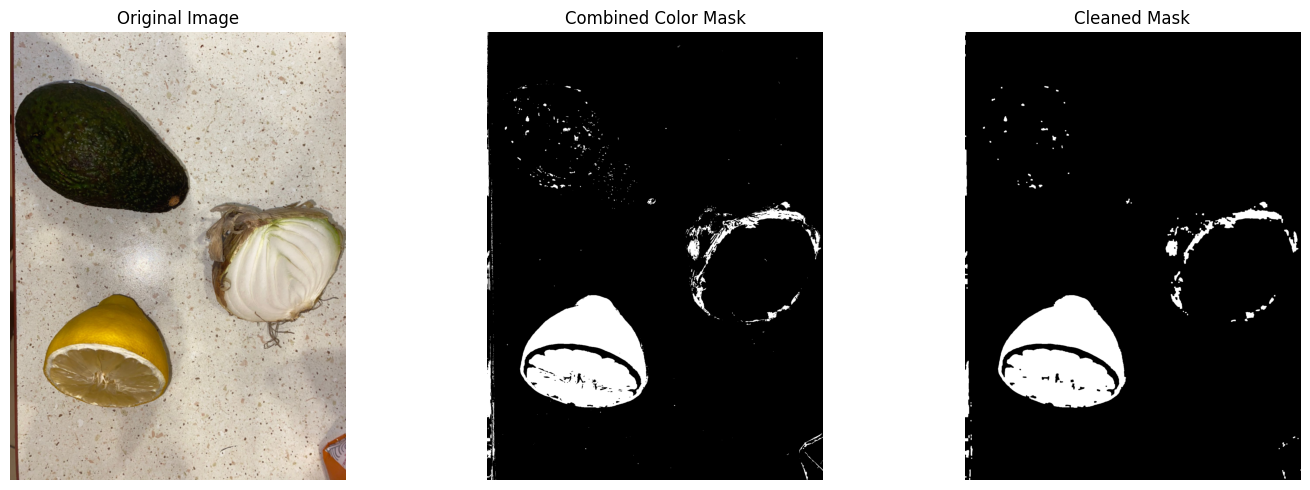

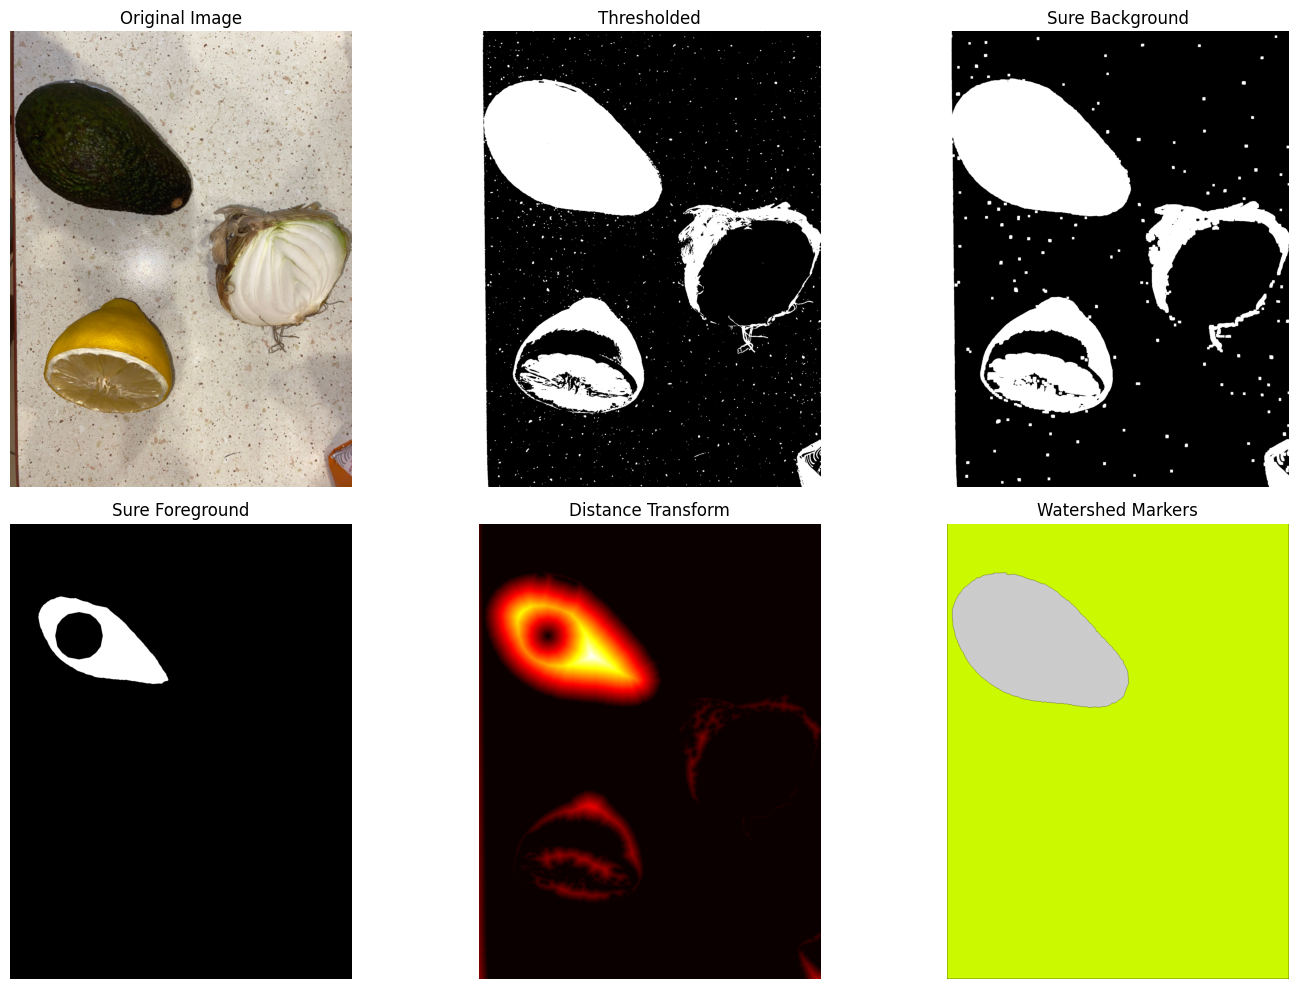

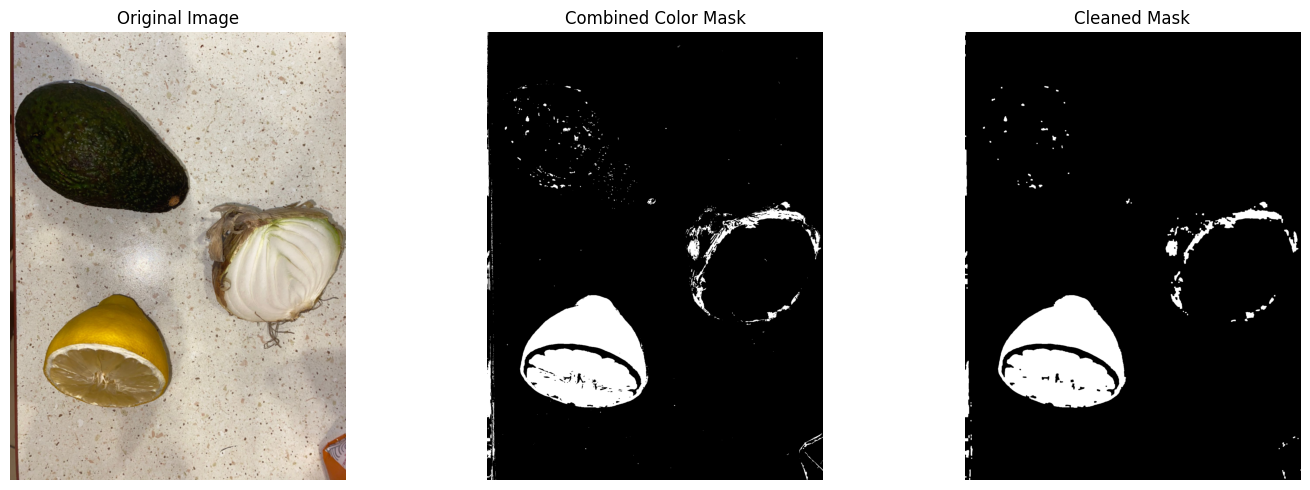

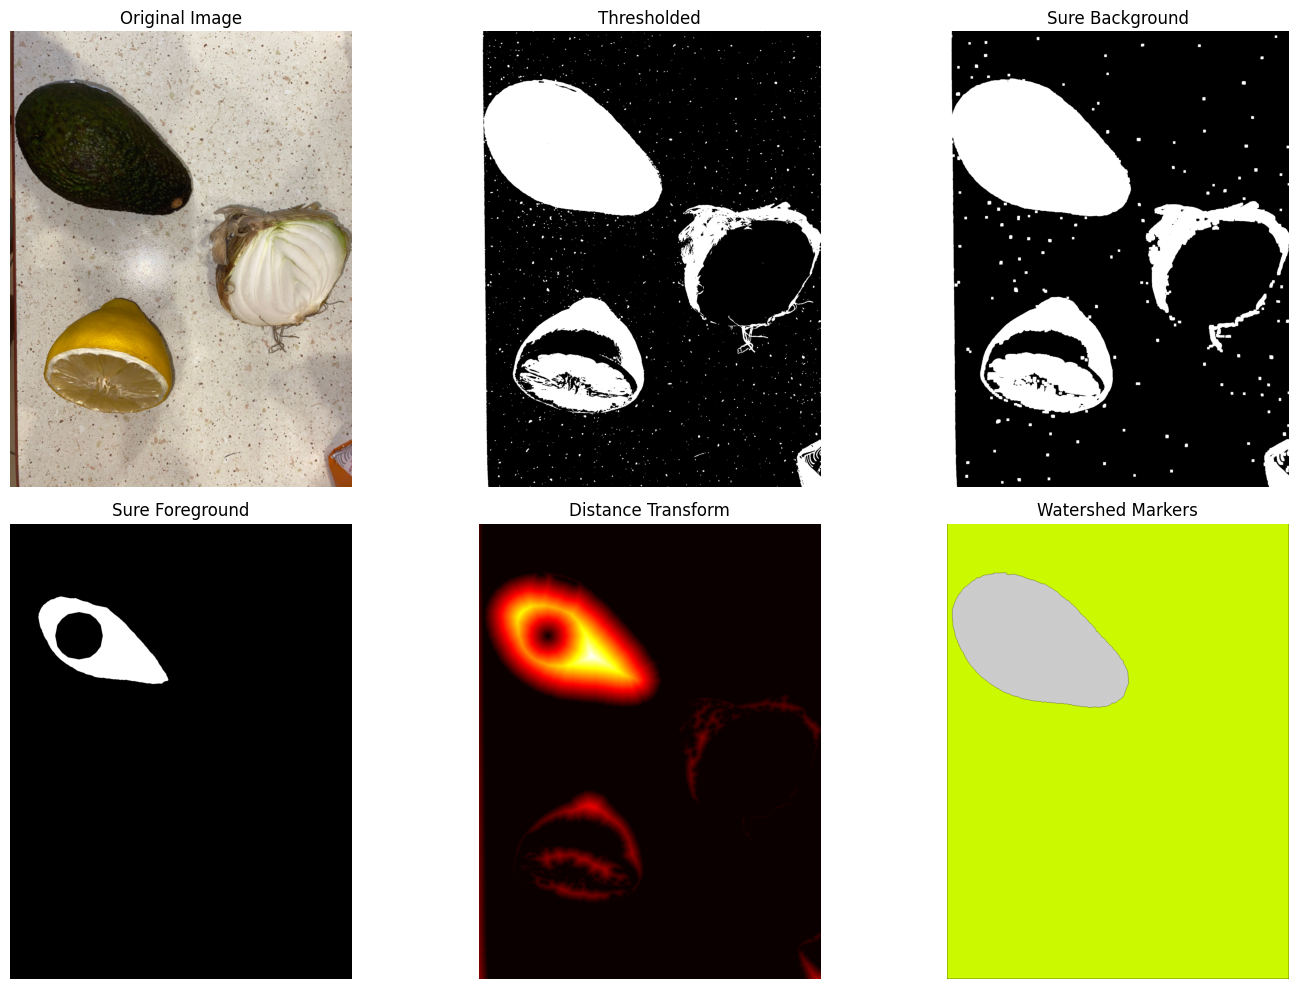

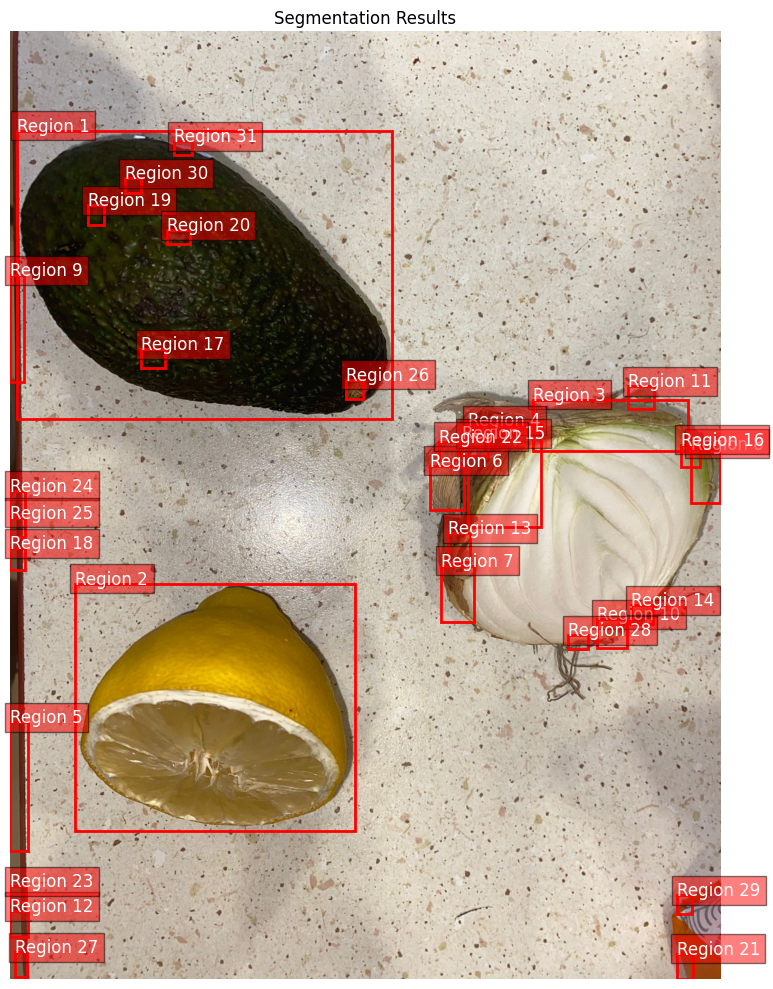

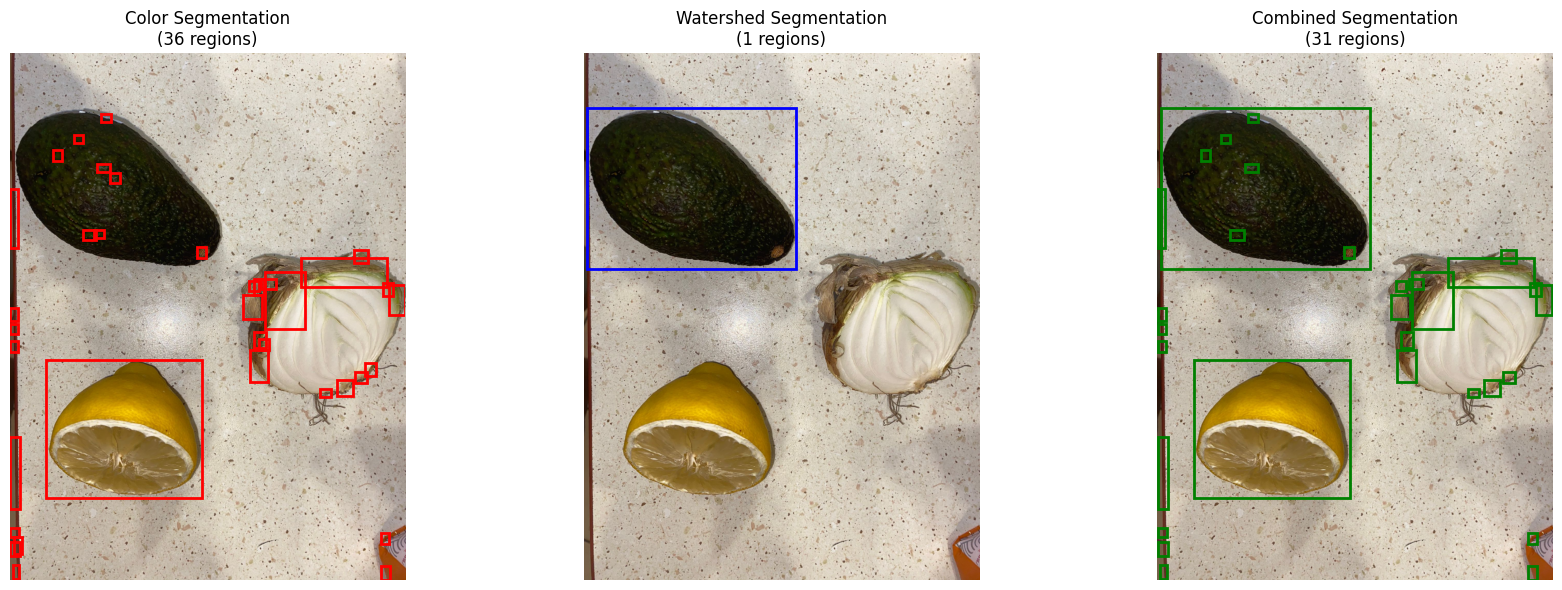

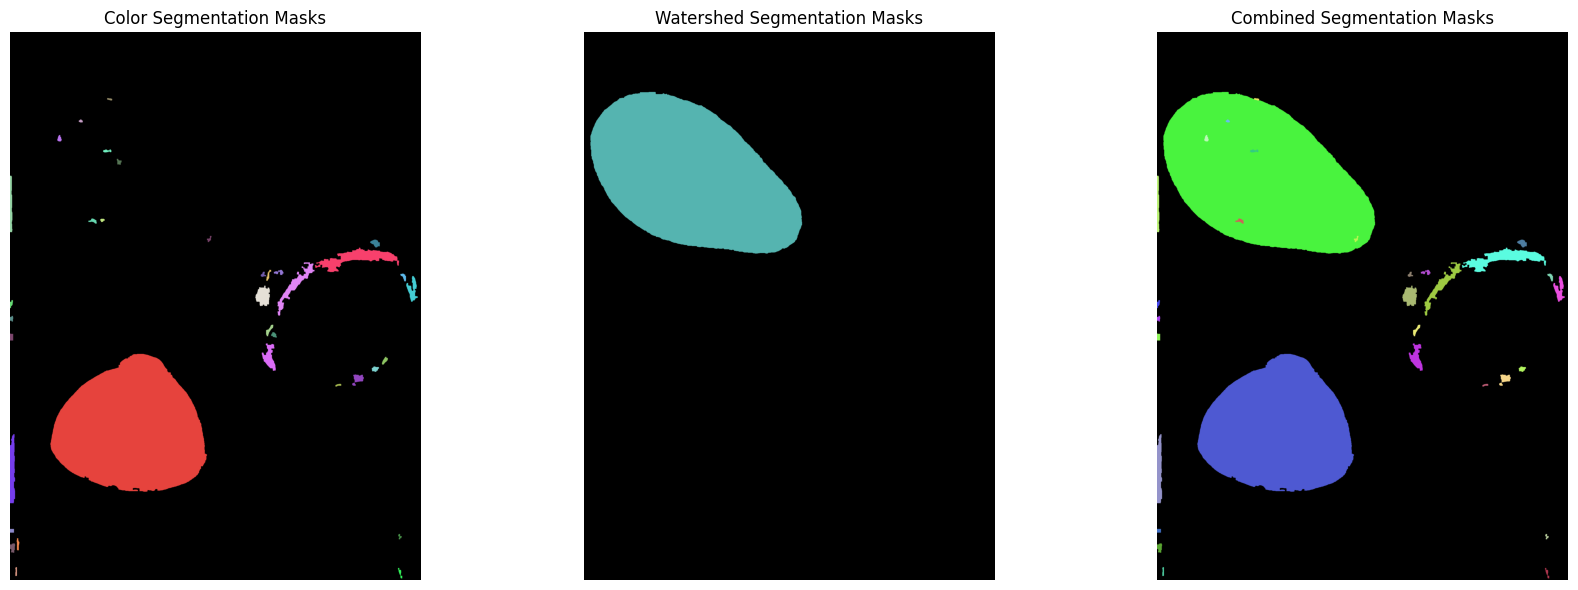

Segmentation comparison:
Color-based segmentation found 36 regions
Watershed segmentation found 1 regions
Combined segmentation found 31 regions


(array([[[106,  88,  64],
         [104,  86,  62],
         [105,  83,  62],
         ...,
         [206, 196, 187],
         [208, 198, 189],
         [209, 199, 190]],
 
        [[104,  86,  62],
         [103,  85,  61],
         [104,  82,  61],
         ...,
         [208, 198, 189],
         [207, 197, 188],
         [205, 195, 186]],
 
        [[104,  86,  62],
         [103,  85,  61],
         [105,  83,  62],
         ...,
         [210, 199, 193],
         [207, 196, 190],
         [203, 192, 186]],
 
        ...,
 
        [[116,  96,  72],
         [116,  96,  72],
         [116,  96,  72],
         ...,
         [146,  65,   9],
         [145,  64,   9],
         [144,  63,   8]],
 
        [[116,  96,  72],
         [116,  96,  72],
         [117,  97,  73],
         ...,
         [146,  65,  10],
         [146,  65,  12],
         [146,  65,  12]],
 
        [[114,  94,  70],
         [115,  95,  71],
         [116,  96,  72],
         ...,
         [146,  65,  10],
  

In [10]:
def visualize_segmentation_samples():
    """
    Demonstrate different segmentation methods on sample images to show
    their strengths and weaknesses
    """
    # Try to find fruit images to test
    test_image_path = None
    val_dir = os.path.join("..", "datasets", "fruits_yolo", "val")
    
    # # Look for an image with multiple fruits for a good demonstration
    # if os.path.exists(val_dir):
    #     for cls_dir in os.listdir(val_dir):
    #         cls_path = os.path.join(val_dir, cls_dir)
    #         if os.path.isdir(cls_path):
    #             images = [f for f in os.listdir(cls_path) if f.endswith(('.jpg', '.png', '.jpeg'))]
    #             if images:
    #                 test_image_path = os.path.join(cls_path, random.choice(images))
    #                 break
    
    # If no image found in dataset, look for a test image
    if test_image_path is None:
        test_image_path = os.path.join("..", "datasets", "fridge_testing", "all-3.png")
    
    # If still no image found, create a synthetic test image
    if not os.path.exists(test_image_path):
        print("Creating synthetic test image for segmentation demonstration...")
        canvas = np.ones((600, 800, 3), dtype=np.uint8) * 240
        cv2.ellipse(canvas, (200, 300), (100, 80), 0, 0, 360, (0, 0, 255), -1)
        cv2.ellipse(canvas, (500, 200), (120, 60), 30, 0, 360, (0, 255, 255), -1)
        cv2.circle(canvas, (400, 400), 70, (0, 255, 0), -1)
        
        test_image_path = os.path.join(results_dir, "segmentation_demo.jpg")
        cv2.imwrite(test_image_path, cv2.cvtColor(canvas, cv2.COLOR_RGB2BGR))
    
    print(f"Using test image: {test_image_path}")
    
    # Load and preprocess the image
    original, processed = preprocess_image(test_image_path)
    
    # Apply different segmentation methods
    color_regions = segment_by_color(processed, show_steps=True)
    watershed_regions = segment_with_watershed(processed, show_steps=True)
    combined_regions = combined_segmentation(test_image_path, show_steps=True)[1]
    
    # Compare the results side by side
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Original image with color-based segmentation regions
    axes[0].imshow(original)
    axes[0].set_title(f'Color Segmentation\n({len(color_regions)} regions)')
    for region in color_regions:
        x, y, w, h = region['bbox']
        rect = plt.Rectangle((x, y), w, h, linewidth=2, edgecolor='r', facecolor='none')
        axes[0].add_patch(rect)
    
    # Original image with watershed segmentation regions
    axes[1].imshow(original)
    axes[1].set_title(f'Watershed Segmentation\n({len(watershed_regions)} regions)')
    for region in watershed_regions:
        x, y, w, h = region['bbox']
        rect = plt.Rectangle((x, y), w, h, linewidth=2, edgecolor='b', facecolor='none')
        axes[1].add_patch(rect)
    
    # Original image with combined segmentation regions
    axes[2].imshow(original)
    axes[2].set_title(f'Combined Segmentation\n({len(combined_regions)} regions)')
    for region in combined_regions:
        x, y, w, h = region['bbox']
        rect = plt.Rectangle((x, y), w, h, linewidth=2, edgecolor='g', facecolor='none')
        axes[2].add_patch(rect)
    
    for ax in axes:
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Show segmentation masks for a clearer view
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Create visualization masks
    color_mask = np.zeros_like(original)
    for i, region in enumerate(color_regions):
        mask = region['mask']
        color = np.array([random.randint(50, 255), random.randint(50, 255), random.randint(50, 255)])
        color_mask[mask > 0] = color
    
    watershed_mask = np.zeros_like(original)
    for i, region in enumerate(watershed_regions):
        mask = region['mask']
        color = np.array([random.randint(50, 255), random.randint(50, 255), random.randint(50, 255)])
        watershed_mask[mask > 0] = color
    
    combined_mask = np.zeros_like(original)
    for i, region in enumerate(combined_regions):
        mask = region['mask']
        color = np.array([random.randint(50, 255), random.randint(50, 255), random.randint(50, 255)])
        combined_mask[mask > 0] = color
    
    # Display the masks
    axes[0].imshow(color_mask)
    axes[0].set_title('Color Segmentation Masks')
    
    axes[1].imshow(watershed_mask)
    axes[1].set_title('Watershed Segmentation Masks')
    
    axes[2].imshow(combined_mask)
    axes[2].set_title('Combined Segmentation Masks')
    
    for ax in axes:
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print("Segmentation comparison:")
    print(f"Color-based segmentation found {len(color_regions)} regions")
    print(f"Watershed segmentation found {len(watershed_regions)} regions")
    print(f"Combined segmentation found {len(combined_regions)} regions")
    
    return original, color_regions, watershed_regions, combined_regions

# Run the visualization
visualize_segmentation_samples()

## 5. Test on Sample Images

Let's test our segmentation + classification approach on some sample images.

Processing test image 1/4: ../datasets/fruits_yolo/val/banana/Banana 4_r1_170_100.jpg

0: 224x224 banana 0.96, zucchini 0.04, blueberry 0.00, dates 0.00, cactus fruit 0.00, 3.2ms
Speed: 9.9ms preprocess, 3.2ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)
0: 224x224 banana 0.96, zucchini 0.04, blueberry 0.00, dates 0.00, cactus fruit 0.00, 3.2ms
Speed: 9.9ms preprocess, 3.2ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)


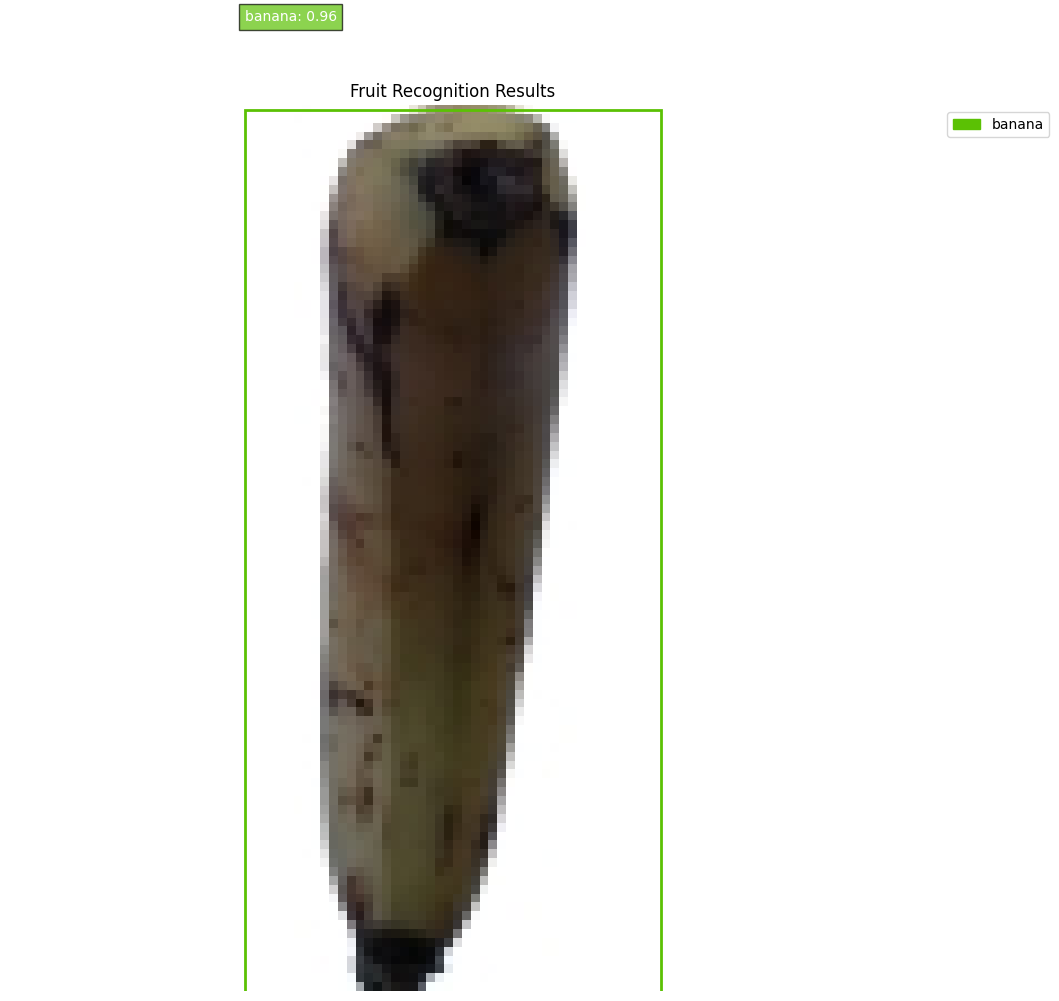

Results saved to ../results/fruit_segmentation/result_Banana 4_r1_170_100.jpg and ../results/fruit_segmentation/result_Banana 4_r1_170_100.json
Detected 1 fruits:
  1. banana (confidence: 0.9566)


Processing test image 2/4: ../datasets/fruits_yolo/val/cantaloupe/Cantaloupe 2_306_100.jpg

0: 224x224 cantaloupe 1.00, cocos 0.00, pomelo 0.00, kiwi 0.00, limes 0.00, 4.4ms
Speed: 5.6ms preprocess, 4.4ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)
0: 224x224 cantaloupe 1.00, cocos 0.00, pomelo 0.00, kiwi 0.00, limes 0.00, 4.4ms
Speed: 5.6ms preprocess, 4.4ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)


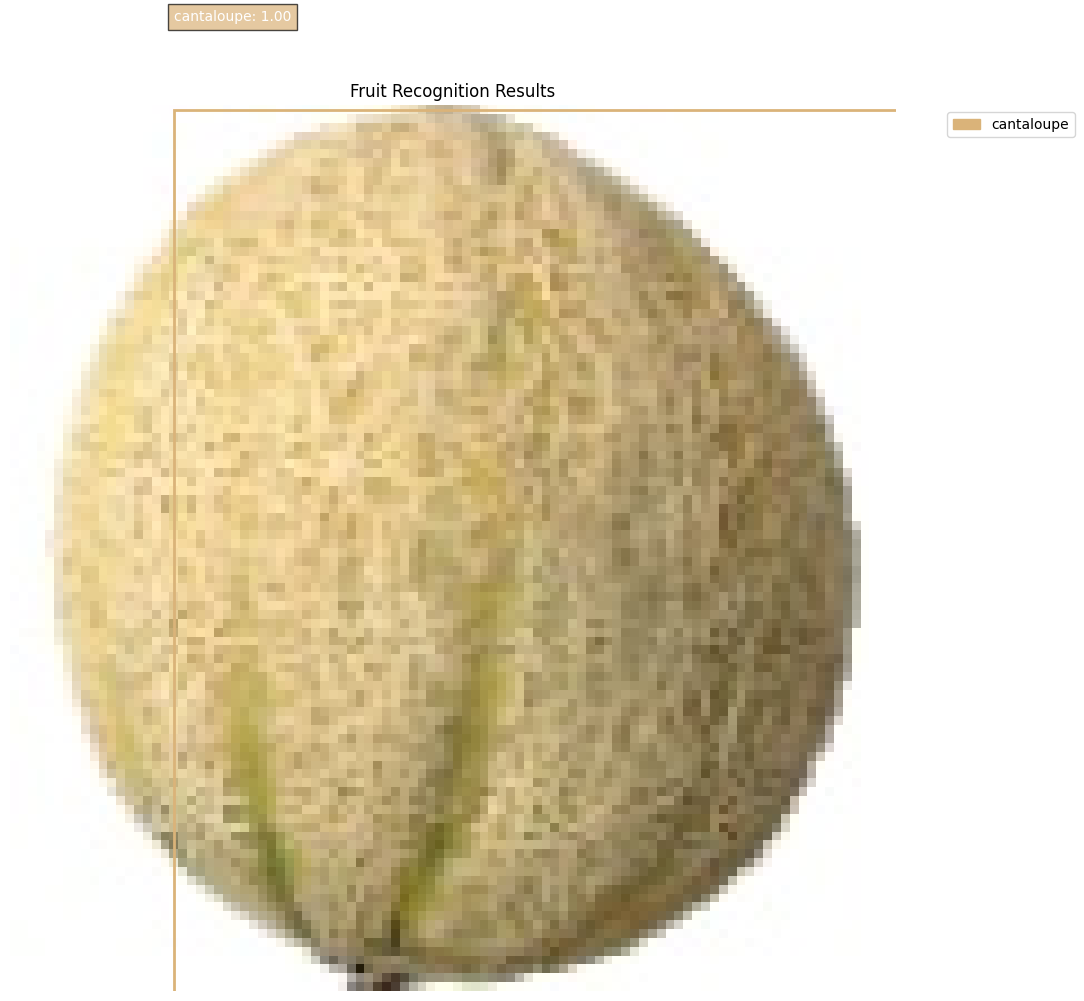

Results saved to ../results/fruit_segmentation/result_Cantaloupe 2_306_100.jpg and ../results/fruit_segmentation/result_Cantaloupe 2_306_100.json
Detected 1 fruits:
  1. cantaloupe (confidence: 1.0000)


Processing test image 3/4: ../datasets/fruits_yolo/val/granadilla/Granadilla 1_r_245_100.jpg

0: 224x224 huckleberry 0.85, blueberry 0.05, pear 0.04, granadilla 0.01, maracuja 0.01, 3.1ms
Speed: 1.4ms preprocess, 3.1ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)
0: 224x224 huckleberry 0.85, blueberry 0.05, pear 0.04, granadilla 0.01, maracuja 0.01, 3.1ms
Speed: 1.4ms preprocess, 3.1ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)


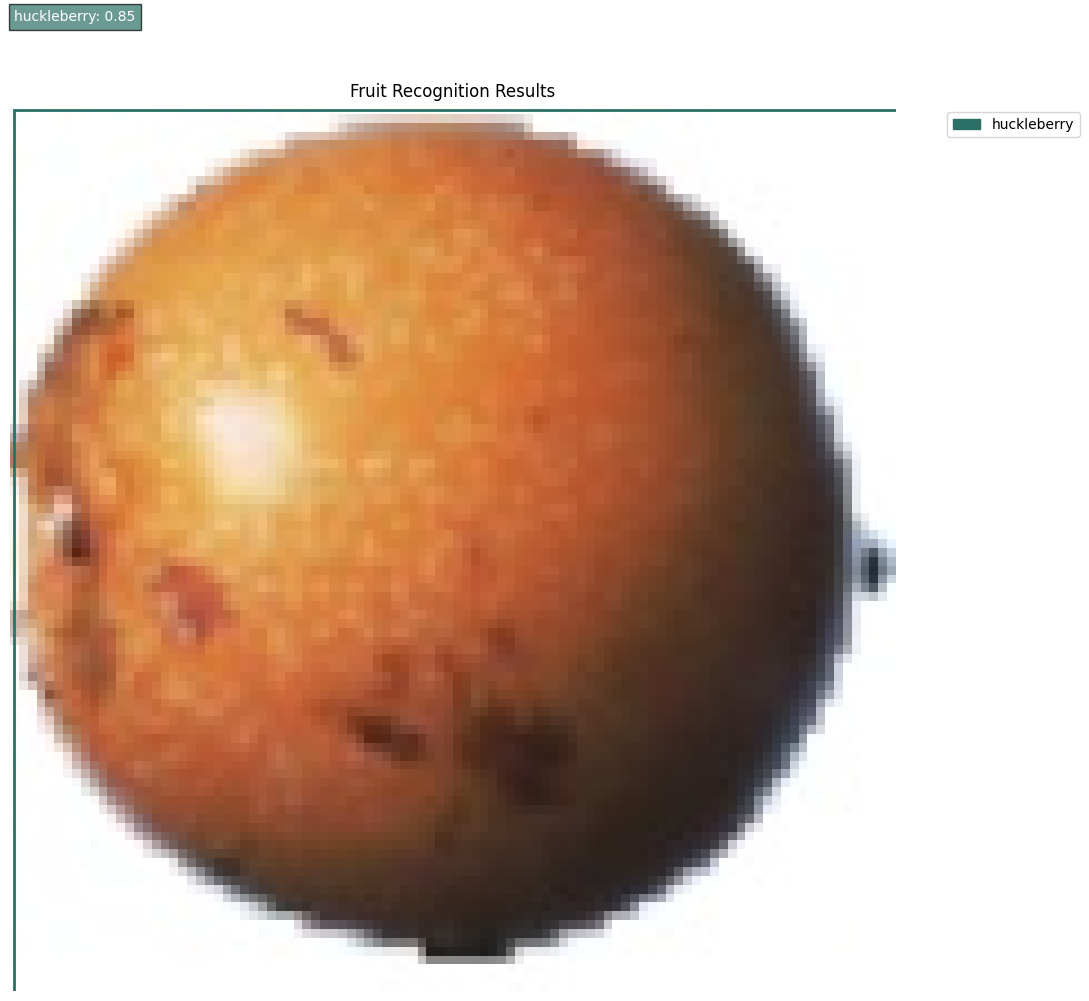

Results saved to ../results/fruit_segmentation/result_Granadilla 1_r_245_100.jpg and ../results/fruit_segmentation/result_Granadilla 1_r_245_100.json
Detected 1 fruits:
  1. huckleberry (confidence: 0.8545)


Processing test image 4/4: ../datasets/fridge_testing/all-3.png

0: 224x224 avocado 0.91, cocos 0.07, rambutan 0.01, pear 0.01, apple 0.00, 2.7ms
Speed: 3.3ms preprocess, 2.7ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)


0: 224x224 avocado 0.91, cocos 0.07, rambutan 0.01, pear 0.01, apple 0.00, 2.7ms
Speed: 3.3ms preprocess, 2.7ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

0: 224x224 corn 0.90, cocos 0.09, onion 0.00, plum 0.00, cabbage 0.00, 2.7ms
Speed: 2.5ms preprocess, 2.7ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

0: 224x224 corn 1.00, cabbage 0.00, cantaloupe 0.00, dates 0.00, melon 0.00, 3.0ms
Speed: 1.6ms preprocess, 3.0ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

0: 224x224 corn

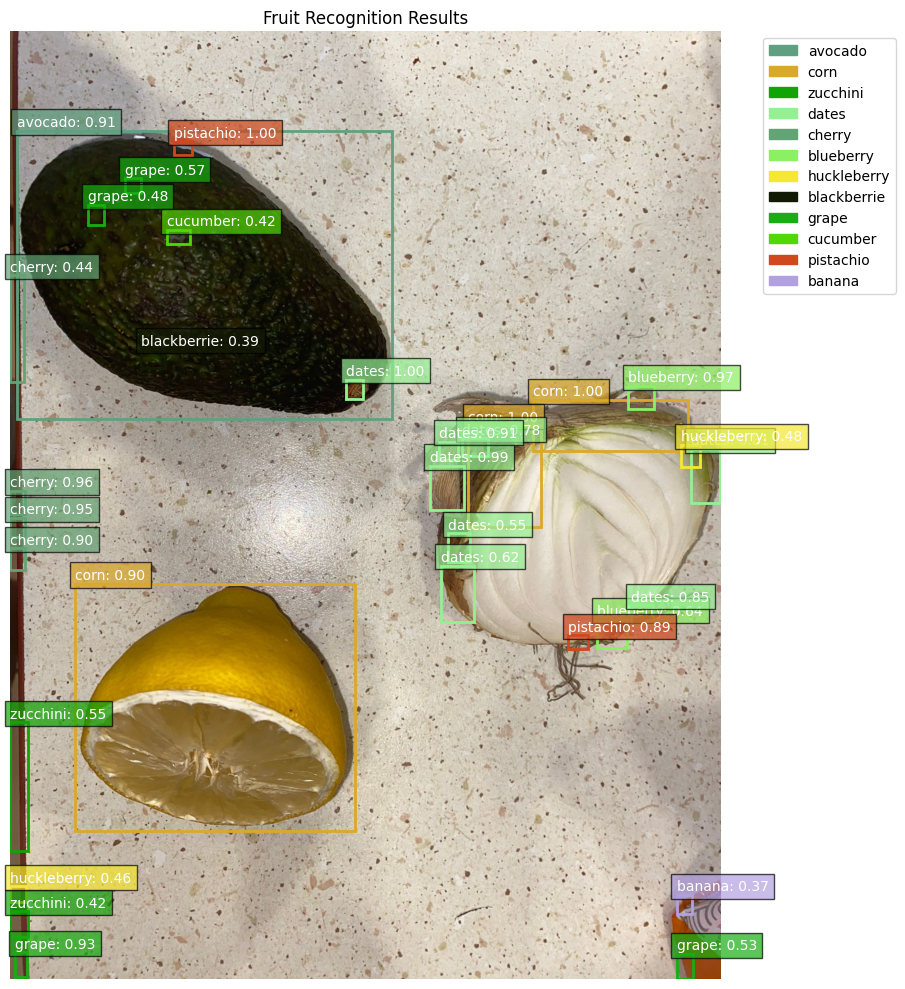

Results saved to ../results/fruit_segmentation/result_all-3.png and ../results/fruit_segmentation/result_all-3.json
Detected 31 fruits:
  1. avocado (confidence: 0.9141)
  2. corn (confidence: 0.9035)
  3. corn (confidence: 0.9999)
  4. corn (confidence: 0.9996)
  5. zucchini (confidence: 0.5509)
  6. dates (confidence: 0.9933)
  7. dates (confidence: 0.6166)
  8. dates (confidence: 0.8144)
  9. cherry (confidence: 0.4369)
  10. blueberry (confidence: 0.6415)
  11. blueberry (confidence: 0.9710)
  12. zucchini (confidence: 0.4181)
  13. dates (confidence: 0.5543)
  14. dates (confidence: 0.8533)
  15. dates (confidence: 0.7778)
  16. huckleberry (confidence: 0.4793)
  17. blackberrie (confidence: 0.3929)
  18. cherry (confidence: 0.9041)
  19. grape (confidence: 0.4847)
  20. cucumber (confidence: 0.4227)
  21. grape (confidence: 0.5289)
  22. dates (confidence: 0.9114)
  23. huckleberry (confidence: 0.4643)
  24. cherry (confidence: 0.9578)
  25. cherry (confidence: 0.9540)
  26. date

In [8]:
# Test on a sample image from the dataset
def test_on_sample():
    # Try to find some fruit images to test
    test_paths = []
    
    # Look in the validation set
    val_dir = os.path.join("..", "datasets", "fruits_yolo", "val")
    if os.path.exists(val_dir):
        classes = os.listdir(val_dir)
        if classes:
            # Pick a few random classes
            sample_classes = random.sample(classes, min(3, len(classes)))
            for cls in sample_classes:
                cls_dir = os.path.join(val_dir, cls)
                if os.path.isdir(cls_dir):
                    images = [f for f in os.listdir(cls_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]
                    if images:
                        test_paths.append(os.path.join(cls_dir, random.choice(images)))
    
    # Add a custom test path if provided
    custom_test = os.path.join("..", "datasets", "fridge_testing", "all-3.png")
    if os.path.exists(custom_test):
        test_paths.append(custom_test)
    
    # If no test images found, create a synthetic test image
    if not test_paths:
        print("No test images found. Creating a synthetic test image...")
        
        # Create a blank canvas
        canvas = np.ones((600, 800, 3), dtype=np.uint8) * 240  # Light gray background
        
        # Draw some colored circles/ellipses to simulate fruits
        cv2.ellipse(canvas, (200, 300), (100, 80), 0, 0, 360, (0, 0, 255), -1)  # Red "apple"
        cv2.ellipse(canvas, (500, 200), (120, 60), 30, 0, 360, (0, 255, 255), -1)  # Yellow "banana"
        cv2.circle(canvas, (400, 400), 70, (0, 255, 0), -1)  # Green "apple"
        
        # Save the synthetic image
        synthetic_path = os.path.join(results_dir, "synthetic_test.jpg")
        cv2.imwrite(synthetic_path, cv2.cvtColor(canvas, cv2.COLOR_RGB2BGR))
        test_paths = [synthetic_path]
    
    # Process each test image
    for i, img_path in enumerate(test_paths):
        print(f"Processing test image {i+1}/{len(test_paths)}: {img_path}")
        results = process_image(img_path, classifier, class_names, show_results=True, save_results=True)
        
        # Print the detected fruits
        print(f"Detected {len(results)} fruits:")
        for i, r in enumerate(results):
            print(f"  {i+1}. {r['class']} (confidence: {r['confidence']:.4f})")
        
        print("\n")

# Run the test
test_on_sample()

## 6. Interactive Processing Function

Let's create a function that allows the user to process any image.

In [ ]:
def process_user_image(image_path):
    """
    Process a user-provided image
    
    Args:
        image_path: Path to the image
    """
    if not os.path.exists(image_path):
        print(f"Error: Image not found at {image_path}")
        return
    
    print(f"Processing image: {image_path}")
    results = process_image(image_path, classifier, class_names, show_results=True, save_results=True)
    
    # Summarize the results
    fruits_count = {}
    for r in results:
        class_name = r['class']
        fruits_count[class_name] = fruits_count.get(class_name, 0) + 1
    
    print("\nSummary of detected fruits:")
    for cls, count in fruits_count.items():
        print(f"  {cls}: {count}")
    
    return results

# Example usage:
# process_user_image("/path/to/your/image.jpg")

## 7. Comparison with Direct Object Detection

Let's compare our segmentation + classification approach with a direct object detection approach.

In [ ]:
def compare_with_detection(image_path):
    """
    Compare our segmentation+classification approach with direct object detection
    
    Args:
        image_path: Path to the image
    """
    if not os.path.exists(image_path):
        print(f"Error: Image not found at {image_path}")
        return
    
    # Load a detection model
    try:
        detector = YOLO("yolov8n.pt")  # Standard YOLOv8 model with COCO classes
    except Exception as e:
        print(f"Error loading detection model: {e}")
        return
    
    # Process with our approach
    print("Processing with segmentation + classification approach...")
    seg_results = process_image(image_path, classifier, class_names, show_results=True, save_results=False)
    
    # Process with direct detection
    print("Processing with direct object detection...")
    det_results = detector(image_path)
    
    # Display detection results
    plt.figure(figsize=(12, 10))
    det_img = cv2.imread(image_path)
    det_img = cv2.cvtColor(det_img, cv2.COLOR_BGR2RGB)
    plt.imshow(det_img)
    plt.title('Direct Object Detection Results')
    
    # Draw detection results
    for result in det_results:
        boxes = result.boxes
        for box in boxes:
            # Get box coordinates
            x1, y1, x2, y2 = box.xyxy[0].cpu().numpy().astype(int)
            
            # Get class and confidence
            class_id = int(box.cls.cpu().numpy()[0])
            conf = float(box.conf.cpu().numpy()[0])
            
            # Get class name from COCO dataset
            class_name = result.names[class_id]
            
            # Draw bounding box
            rect = plt.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, edgecolor='b', facecolor='none')
            plt.gca().add_patch(rect)
            
            # Add label
            label = f"{class_name}: {conf:.2f}"
            plt.text(x1, y1-10, label, color='white', fontsize=10,
                    bbox=dict(facecolor='blue', alpha=0.7))
    
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    # Compare the number of detections
    print(f"\nSegmentation + Classification: {len(seg_results)} fruits detected")
    print(f"Direct Object Detection: {len(det_results[0].boxes)} objects detected")
    
    return seg_results, det_results

# Example usage:
# compare_with_detection("/path/to/your/image.jpg")

## 8. Summary and Conclusions

Our two-stage approach (segmentation + classification) offers several advantages:

1. **Precision**: By separating segmentation from classification, we can optimize each step independently
2. **Adaptability**: The segmentation can be tuned for different lighting conditions and backgrounds
3. **Specificity**: Our classification model is specifically trained on fruits, giving more accurate results than general object detection
4. **Granularity**: We can detect and classify specific fruit varieties that general models might miss

Limitations and potential improvements:

1. **Speed**: The two-stage approach is slower than direct object detection
2. **Integration**: Further refinement could improve how the segmentation and classification work together
3. **Segmentation Quality**: More advanced segmentation algorithms (e.g., U-Net) could improve results
4. **Training Data**: Adding more diverse images would improve segmentation robustness

Overall, this approach works well for specific applications where precise fruit identification is needed, such as inventory management in refrigerators or fruit quality assessment.